In [1]:
import pandas as pd
# import os
# from glob import glob
# import numpy as np
from level2_utils import get_data_for_confirmed_train_subjs, read_yaml_for_host
# from level2_utils import *
import sys
sys.path.append('/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/')
from dev_interaction_util import load_groups_from_mastersheet

config_data = read_yaml_for_host("l2_config.yml")
# nonbids_data_path = config_data['nonbids_data_path']
# ml_data_folderpath = nonbids_data_path + "fMRI/ml"
# dev_scripts_path = config_data['dev_scripts_path']
# ml_scripting_path = dev_scripts_path + "/fMRI/ml"
dropbox_datapath = config_data['dropbox_datapath']
sst_level_2_path = config_data['sst_level_2_path']

spm_path = config_data['spm_path']

analysis_name = 'health_conditions'

output_name = analysis_name + '_groups'

groups_by_name = load_groups_from_mastersheet(dropbox_datapath + 'DEV Participant Mastersheet_copy.xlsx')


Benjamins-MacBook-Pro-2.local


In [2]:
dir_for_analysis = sst_level_2_path + 'health_conditions_groups_20230908/raw_filelist.csv'

In [3]:
analysis_subject_table_raw = pd.read_csv(dir_for_analysis,index_col=0)
groups_by_name = load_groups_from_mastersheet(dropbox_datapath + 'DEV Participant Mastersheet_copy.xlsx')

#merge on subject ID
analysis_subject_table = analysis_subject_table_raw.merge(groups_by_name, how='left', left_on='subject_id', right_on='dev_id')

In [4]:
analysis_subject_table.intervention_group

0          umpqua
1      willamette
2        mckenzie
3        mckenzie
4        mckenzie
          ...    
180    willamette
181    willamette
182      mckenzie
183    willamette
184      mckenzie
Name: intervention_group, Length: 185, dtype: object

In [5]:
roi_table_path = sst_level_2_path + 'health_conditions_groups_20230908/Unhealthy_NoGo(W2-W1)/rois_raw.csv'

roi_table_1 = pd.read_csv(roi_table_path)
roi_table_insula_path = sst_level_2_path + 'health_conditions_groups_20230908/Unhealthy_NoGo(W2-W1)/rois_raw_insula.csv'
roi_table_insula = pd.read_csv(roi_table_insula_path)



spm_roi_table = pd.concat([roi_table_1,roi_table_insula],axis=1)

In [6]:
spm_roi_table_vars = spm_roi_table.columns.values

In [7]:
roi_table_functional_path = '/Users/benjaminsmith/Dropbox (University of Oregon)/UO-SAN Lab/Berkman Lab/Devaluation/analysis_files/data/subject_sst_health_avg_roi_data_raw.csv'
roi_table_functional = pd.read_csv(roi_table_functional_path,index_col=0)


In [8]:
roi_table_functional_mask_names = roi_table_functional.mask_label.unique()
#transform wider using mask_label as the column names and roi_activity as the values
roi_table_functional_wide = roi_table_functional.pivot(
    index=['subject_id'],
    columns=['condition','mask_label'],
    values='roi_activity')

#now flatten the column names
roi_table_functional_wide.columns = ['_'.join(col).strip() for col in roi_table_functional_wide.columns.values]
roi_table_functional_wide = roi_table_functional_wide.reset_index()

In [9]:
subjects_with_rois = pd.concat([analysis_subject_table,spm_roi_table, roi_table_functional_wide[roi_table_functional_wide.columns[1:]]],axis=1)

roi_table_functional_mask_names = roi_table_functional_wide.columns.values[1:]

OK, we have the data, now let's do some contrasts. Contrast umpqua and mckenzie with willamette on both ROIs using a t-test

In [10]:
roi_colnames = spm_roi_table_vars.tolist() + roi_table_functional_mask_names.tolist()

In [11]:

from scipy.stats import ttest_ind
import numpy as np

for roi_colname in roi_colnames:
    print(roi_colname)
    for experimental_group in ['umpqua','mckenzie']:
        print(experimental_group)
        control_group_data = subjects_with_rois.loc[subjects_with_rois['intervention_group'] == 'willamette',roi_colname]
        experimental_group_data = subjects_with_rois.loc[subjects_with_rois['intervention_group'] == experimental_group,roi_colname]
        #do independent-samples t-test

        t,p = ttest_ind(control_group_data,experimental_group_data)
        print('cont: ' + str(np.mean(control_group_data)) + '; exp: ' + str(np.mean(experimental_group_data)))
        print("t-score: " + str(t) + "; p-val: " + str(p))
    print("")
        
        

y_neurosynth_response_inhibition_sfg_mean
umpqua
cont: -0.0308151399051091; exp: -0.27559420416917163
t-score: 1.279082559606822; p-val: 0.20342077457535257
mckenzie
cont: -0.0308151399051091; exp: -0.16985442180931276
t-score: 0.7066817055846746; p-val: 0.48110088299551146

y_neurosynth_response_inhibition_right_frontal_pole_mean
umpqua
cont: 0.08508119824550762; exp: -0.3962944158715766
t-score: 2.1969134550119787; p-val: 0.030014637607882647
mckenzie
cont: 0.08508119824550762; exp: 0.04941347927760869
t-score: 0.1697188204174757; p-val: 0.8655100948473187

y_neurosynth_response_inhibition_insula_mean
umpqua
cont: -0.0011634111929030462; exp: -0.04229824826530074
t-score: 0.30739005076590475; p-val: 0.7590976844058896
mckenzie
cont: -0.0011634111929030462; exp: -0.1349143194361554
t-score: 1.0105010546056485; p-val: 0.31423901092434126

Unhealthy_NoGo(W2-W1)_response inhibition_association-test_z_FDR_0.01
umpqua
cont: -0.030416314034482764; exp: -0.15848712311666666
t-score: 1.374695

Perhaps there is a way to confirm this by looking at the behavioral response modification? We have a measure of which subjects changed their responses the most; does it relate to the change score we are measuring in these ROIs?

# Pre-registered


## Reward responsivity

According to BRT theory, BR Training (vs. Control) decreases reward response activity to unhealthy foods


We have tested this prediction, and found no decreased reward response activity in relation to unhealthy foods in the Stop trials. This is probably better tested in Go trials...


## Response inhibition

- Two theories about the neural mechanism of BRT:
    1. In the **pure response** account, it operates by building up response inhibition to unhealthy foods during Stop trials
        
        If this is true we will expect to see *increased* response inhibition activity in BR Training (vs Control) during Stop trials
        
        (tested, n.s.)

    2. In the **value modification** account, it operates by changing underlying values of of unhealthy foods
        
        If this is true we’d expect to see **decreased** response inhibition activity in BR Training (vs. Control)

        (tested, n.s.)
        
- Cognitive re-appraisal: Again we can have two accounts for neural mechanisms of cognitive reappraisal, **value modification** and **deliberative reframing via response inhibition**
    - In the *value modification* account, we see **decreased** response inhibition activity in CR Training (vs. Control)
    (tested, may be a decrease from t1 to t2)

    - In **deliberative reframing via response inhibition**, we see **increased** response inhibition activity in CR Training

    (tested, contrary evidence)


Could try controlling all of teh above for age_z, gender.


## Valuation

1. In the **pure response** account, we should see no change in valuation for BR Training vs. Control

(tested; change n.s.)

2. In the **value modification** account, we should see **decreased** valuation activity during exposure to healthy foods for BR Training (vs. Control)

(I think this is a typo and it means to say unhealthy foods! We should see **increased** valuation of healhty foods! But we failed to see any change here.)

## Dependent variable
- Reaction Time, measuring average Healthy - Unhealthy over the subject's task
- for response inhibition activity we examine whether there exists neural activity in the right dlPFC, or in a neurosynth response inhibition map, i.e., whether there exists whole-brain level contrast within those areas, or whether there exists significant activity change specifically within the neurosynth response inhibition map 
- for reward responsivity we will examine activity whole-brain level contrast in an anatomical striatum map, or whether there exists significant activity change specifically within a neurosynth reward * anatomical striatum intersection map
- for value we will examine whole-brain level activity contrast within a neurosynth "value" map

## Pre-registration summary

Overall, we found some evidence that cognitive re-appraisal may be effective at decreasing the value of unhealthy foods, evidenced by the _decline_ in response inhibition for unhealthy foods for subjects in this condition.



### Follow-up

We didn't see a significant effect in value change in the vmPFC, however. So we'd want to look for some other kind of evidence that the decilne in response inhibition in the cognitive re-appraisal group is being driven by a decline in value of unhealthy foods, leading to a lower need to inhibit.

We could do taht by correlating decline in response inhibition against the vmPFC signal. Important this is for unhealthy foods specifically.

In [12]:
from scipy.stats import pearsonr

valuation_cols = ['Unhealthy_Go(W2-W1)_value_association_frontal_medial_cortex', #predicted R>0
                  'Unhealthy_NoGo(W2-W1)_value_association_frontal_medial_cortex', #predicted R>0
                  'Unhealthy_NoGo(W2-W1)_striatum_joint_reward_mask' #uncertain
                  ]


resp_inhibition = 'y_neurosynth_response_inhibition_right_frontal_pole_mean'



for group_name in ['umpqua','mckenzie', 'willamette']:
    print(group_name)
    #expecting a significant association for umpqua, but not willamette; mckenzie is unknown
    subj_group_data = subjects_with_rois.loc[subjects_with_rois['intervention_group'] == group_name]
    for valuation_col in valuation_cols:
        print(valuation_col)
        # do a pearson correlation of the valuation_col with resp_inhibition
        # get the correlation coefficient as well as the p-value
        r,p = pearsonr(subj_group_data[valuation_col],subj_group_data[resp_inhibition])
        print("r: " + str(r) + "; p: " + str(p))
    print("\n")

umpqua
Unhealthy_Go(W2-W1)_value_association_frontal_medial_cortex
r: 0.3491931480787027; p: 0.006245617509200468
Unhealthy_NoGo(W2-W1)_value_association_frontal_medial_cortex
r: 0.3962262848900717; p: 0.0017247502714785928
Unhealthy_NoGo(W2-W1)_striatum_joint_reward_mask
r: 0.5322275790793709; p: 1.2047349297338309e-05


mckenzie
Unhealthy_Go(W2-W1)_value_association_frontal_medial_cortex
r: 0.2287384692659089; p: 0.06262603264118556
Unhealthy_NoGo(W2-W1)_value_association_frontal_medial_cortex
r: 0.28603133472283643; p: 0.018952640371529685
Unhealthy_NoGo(W2-W1)_striatum_joint_reward_mask
r: 0.6086368881424832; p: 4.653469141380027e-08


willamette
Unhealthy_Go(W2-W1)_value_association_frontal_medial_cortex
r: 0.28136826331592757; p: 0.0323852618061049
Unhealthy_NoGo(W2-W1)_value_association_frontal_medial_cortex
r: 0.23214132141191257; p: 0.07951774790403221
Unhealthy_NoGo(W2-W1)_striatum_joint_reward_mask
r: 0.5843709964780828; p: 1.464004694712351e-06




NameError: name 'plt' is not defined

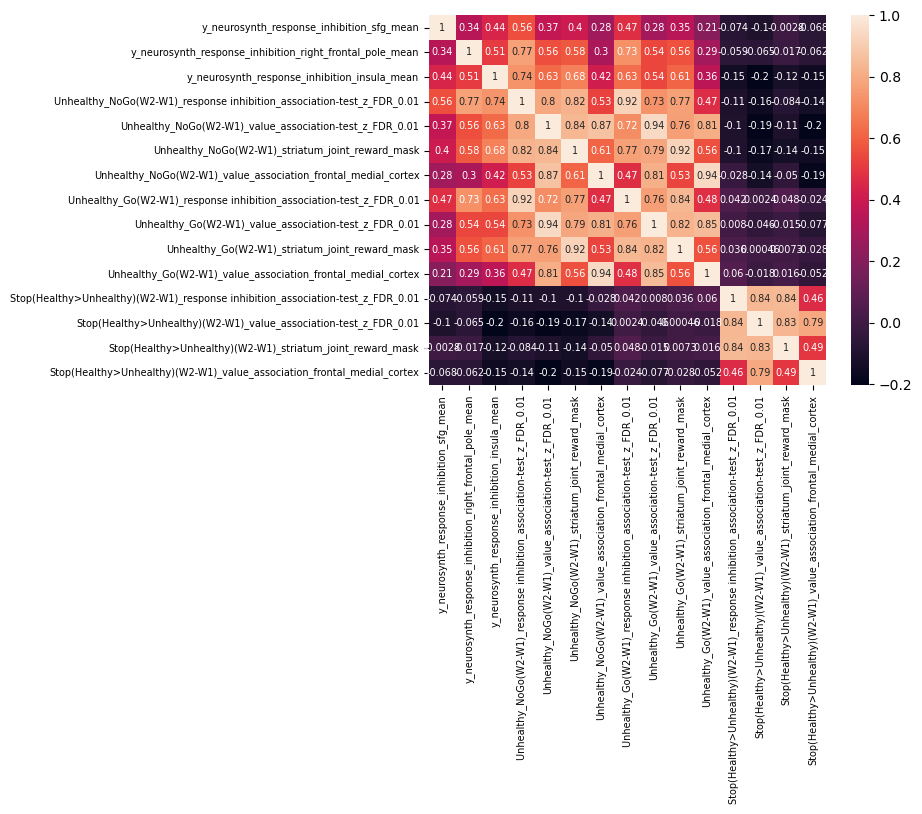

In [13]:
#do a correlation matrix plot for all the valuation_cols
import seaborn as sns


#now do the corrplot
#print a heatmap with two-digit correlation coefficients for each pair of variables
#use annot=True and dont' make the font size too big
corr = subjects_with_rois[roi_colnames].corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            annot_kws={"size": 7}
            )
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)

plt.show()

Perhaps we don't have a proper control because all these ROIs are correlated, and they shouldn't be so highly correlated.

Could check this by getting the mean of each subject's image. If they're not zero, those would be driving the correlation, and we should be doing something different.

## Pre-registration summary

Overall, we found some evidence that 